In [2]:
import pathlib
import os
import time
import base64
from ctypes import byref, cast, POINTER, c_int, c_uint, c_float
import libximc as ximc
import pandas as pd
import numpy as np
import serial

In [3]:
probe_flags = ximc.EnumerateFlags.ENUMERATE_PROBE + ximc.EnumerateFlags.ENUMERATE_NETWORK
enum_hint=b"addr="
devices_info = ximc.lib.enumerate_devices(probe_flags, enum_hint)
n_devices = ximc.lib.get_device_count(devices_info)

# Print real devices list
if n_devices > 0:
    print("Found {} real device(s):".format(n_devices))
    for i in range(n_devices):
        enum_name = ximc.lib.get_device_name(devices_info, i)
        print("  {}".format(enum_name.decode()))
else:
    print("The real devices were not found. A virtual device will be used.")

Found 2 real device(s):
  xi-com:\\.\COM10
  xi-com:\\.\COM9


In [4]:
device_uri_axis1 = "xi-com:\\\\.\\COM10" # horizontal
device_uri_axis2 = "xi-com:\\\\.\\COM9" # vertical
 
device_id1 = ximc.lib.open_device(device_uri_axis1.encode()) # horizontal
device_id2 = ximc.lib.open_device(device_uri_axis2.encode()) # vertical

if device_id1 > 0:
    print("Device with URI {} successfully opened".format(device_uri_axis1))
else:
    raise RuntimeError("Failed to open device with URI", device_uri_axis2)

if device_id2 > 0:
    print("Device with URI {} successfully opened".format(device_uri_axis2))
else:
    raise RuntimeError("Failed to open device with URI", device_uri_axis2)


Device with URI xi-com:\\.\COM10 successfully opened
Device with URI xi-com:\\.\COM9 successfully opened


In [26]:
position1 = ximc.get_position_t()

ximc.lib.get_position(device_id1, byref(position1))
print("Initial position, horizontal:", position1.Position)

position2 = ximc.get_position_t()

ximc.lib.get_position(device_id2, byref(position2))
print("Initial position, vertical:", position2.Position)

pos1, pos2 = position1.Position, position2.Position

Initial position, horizontal: -5213
Initial position, vertical: 1625


In [27]:
print("РЕЗУЛЬТАТ ЮСТИРОВКИ ВДВОЕМ: horizontal {}, vertical {}".format(pos1, pos2))

РЕЗУЛЬТАТ ЮСТИРОВКИ ВДВОЕМ: horizontal -5213, vertical 1625


In [30]:
# ximc.lib.command_move(device_id1, pos1, 0)
# ximc.lib.command_move(device_id2, pos2, 0)

In [28]:
try:
    s = serial.Serial('COM8',115200)
except IOError: 
    print('no counter')

In [32]:
s.reset_input_buffer()
raw = s.readline().decode(errors = 'ignore')
try:
    reading = [int(float(part.strip())) for part in raw.split('\t')]
    print(reading)
except:
    print('хуян.doc')

[2234, 2608, 77]


In [25]:
s.close()

In [40]:
ximc.lib.command_move(device_id1, pos1, 0)
ximc.lib.command_move(device_id2, pos2, 0)

0

In [33]:
N = 5
length = 5
step = 1

columns = np.arange(-N * step + int(pos1), int(pos1) + N * step + step, step)
rows = np.arange(-N * step + int(pos2), int(pos2) + N * step + step, step)

data = pd.DataFrame(index=rows, columns=columns)

for x in columns:

    for y in rows:

        time.sleep(1)

        ximc.lib.command_move(device_id2, int(y), 0)
        ximc.lib.command_move(device_id1, int(x), 0)

        time.sleep(1)

        coin = []
        temp = 0
        for _ in range(length):
            s.reset_input_buffer()
            raw = s.readline().decode(errors = 'ignore')
            try:
                reading = [int(float(part.strip())) for part in raw.split('\t')]
                coin.append(reading[-1])
            except:
                print('хуян.doc')
            
        try:
            temp =  int(np.mean(coin))
        except:
            temp = 0

        data[x][y] = temp
        print(x, y, data[x][y])

    time.sleep(2)

ximc.lib.command_move(device_id1, pos1, 0)
ximc.lib.command_move(device_id2, pos2, 0)

s.close()

-5218 1620 49
-5218 1621 52
-5218 1622 49
-5218 1623 50
-5218 1624 44
-5218 1625 41
-5218 1626 36
-5218 1627 33
-5218 1628 36
-5218 1629 22
-5218 1630 24
-5217 1620 57
-5217 1621 55
-5217 1622 54
-5217 1623 55
-5217 1624 53
-5217 1625 43
-5217 1626 47
-5217 1627 40
-5217 1628 35
-5217 1629 32
-5217 1630 23
-5216 1620 58
-5216 1621 61
-5216 1622 59
-5216 1623 57
-5216 1624 54
хуян.doc
-5216 1625 53
-5216 1626 47
-5216 1627 49
-5216 1628 42
-5216 1629 34
-5216 1630 33
-5215 1620 71
-5215 1621 67
-5215 1622 71
-5215 1623 65
-5215 1624 61
-5215 1625 61
-5215 1626 57
-5215 1627 49
-5215 1628 43
-5215 1629 41
-5215 1630 29
-5214 1620 77
-5214 1621 72
-5214 1622 80
-5214 1623 69
-5214 1624 74
-5214 1625 60
-5214 1626 65
-5214 1627 54
-5214 1628 51
-5214 1629 41
-5214 1630 37
-5213 1620 84
-5213 1621 84
-5213 1622 79
-5213 1623 82
-5213 1624 73
-5213 1625 67
-5213 1626 72
-5213 1627 66
-5213 1628 51
-5213 1629 48
-5213 1630 44
-5212 1620 80
-5212 1621 82
-5212 1622 81
-5212 1623 89
хуян.doc
-5

In [33]:
a = [1, 2, 3, 4]
a[-1]

4

In [34]:
data

,-5218,-5217,-5216,-5215,-5214,-5213,-5212,-5211,-5210,-5209,-5208
1620,49,57,58,71,77,84,80,87,99,100,92
1621,52,55,61,67,72,84,82,93,98,97,98
1622,49,54,59,71,80,79,81,95,97,100,102
1623,50,55,57,65,69,82,89,89,97,99,98
1624,44,53,54,61,74,73,87,87,98,105,99
1625,41,43,53,61,60,67,82,78,81,90,99
1626,36,47,47,57,65,72,68,79,82,83,90
1627,33,40,49,49,54,66,69,71,74,80,82
1628,36,35,42,43,51,51,66,65,69,70,75
1629,22,32,34,41,41,48,48,57,61,62,74


<Axes: >

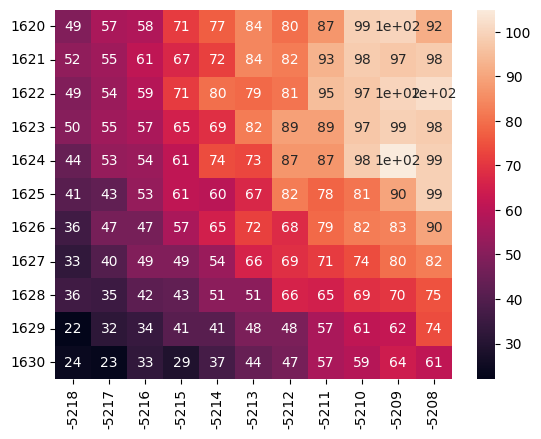

In [38]:
import seaborn as sns
data = data.astype(int)
sns.heatmap(data, annot=True)

In [39]:
ximc.lib.command_move(device_id1, -5208, 0)
ximc.lib.command_move(device_id2, 1620, 0)

0

In [40]:
data.to_csv('измерение 19.07.2023', index=False)